In [1]:
import time
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import uuid

In [2]:
#reference: https://jrtechs.net/data-science/implementing-a-quadtree-in-python

## Node class

In [3]:
# Node class is a rectangle in the quardtree
# with (x0, y0) as coordinates, w as width, h as height
class Node():
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []
        # the unique id for each node
        self.id = uuid.uuid4().hex[:4]

    def get_location(self):
        return (self.x0, self.yo)
    
    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_children(self):
        return self.children

In [4]:
# Method about find the children and parents
# FIND the dictionary of all nodes that can be divide(the leaf)
def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children +=(find_children(child))
    return children

# FIND the dictionary of all nodes that can be fuse(the parent)
def find_parents(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node]
        for child in node.children:
            parent += find_parents(child)
        return parent

## QTree class

In [5]:
# QTree class which can do the divide and graph of quardtree
class QTree():
    def __init__(self):
        self.root = Node(0, 0, 10, 10)
    def subdivide(self, node):
        w_ = float(node.width/2)
        h_ = float(node.height/2)
        x1 = Node(node.x0, node.y0, w_, h_)
        x2 = Node(node.x0, node.y0+h_, w_, h_)
        x3 = Node(node.x0 + w_, node.y0, w_, h_)
        x4 = Node(node.x0+w_, node.y0+h_, w_, h_)
        node.children = [x1, x2, x3, x4]
    def weld(self, node):
        node.children = []
    def graph(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        plt.title("Quadtree")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.height)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            #print((n.x0, n.y0), n.width, n.height)
            rect = patches.Rectangle((n.x0, n.y0), n.width, n.height, fill=False)
            ax.add_patch(rect)
        patches_list = ax.patches
        plt.show()

## Example

Number of segments: 16
Minimum segment area: 0.391 units


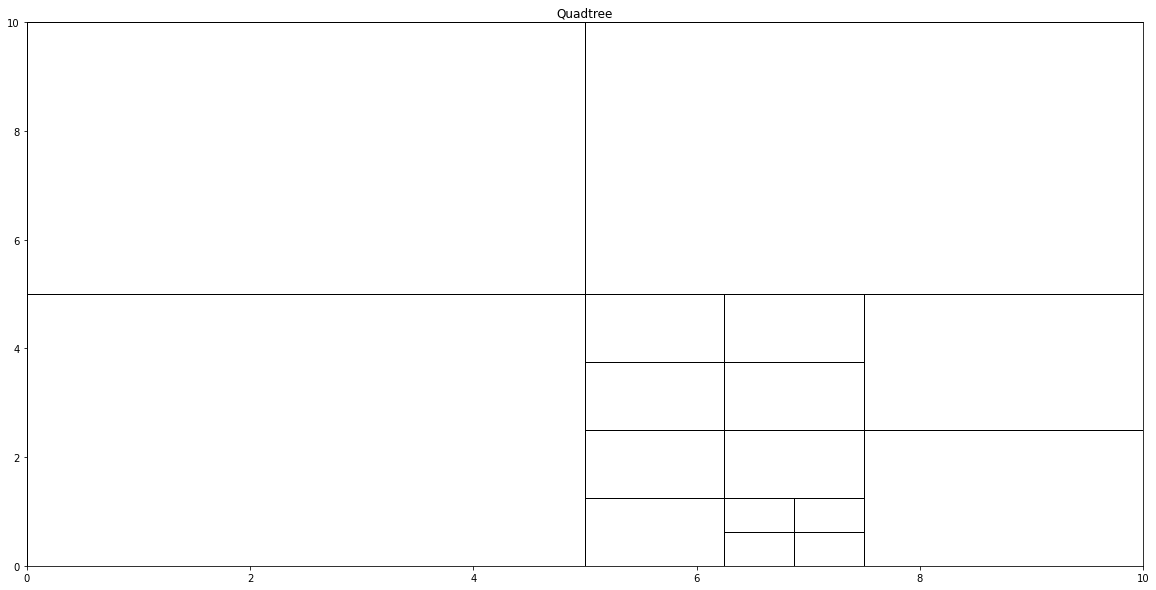

In [52]:
import random
# example of using QTreee 
quard = QTree()

# Divide random times between 0 and 5
for i in range(random.randint(0, 5)):
    # Divide random parent node
    index = random.randint(0,len(find_children(quard.root))-1)
    #print("Divide: ", find_children(quard.root)[index].id)
    quard.subdivide(find_children(quard.root)[index])

# Weld random times between 0 and 5
for i in range(random.randint(0, 5)):
    # Weld random child node to a parent node
    if len(find_parents(quard.root)) == 0:
        break
    if len(find_parents(quard.root)) == 1:
        #print("Weld the children of: ", find_parents(quard.root)[0].id)
        quard.weld(find_parents(quard.root)[0])
        break
    index = random.randint(0,len(find_parents(quard.root))-1)
    #print("Weld the children of: ", find_parents(quard.root)[index].id)
    quard.weld(find_parents(quard.root)[index])
quard.graph() 

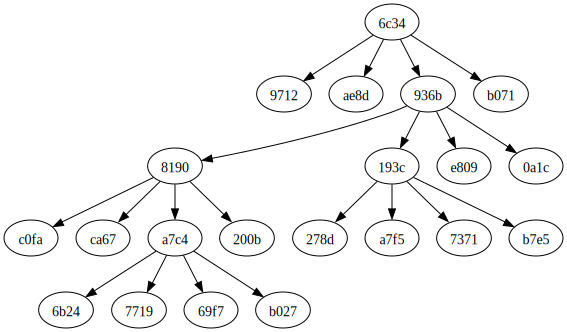

In [53]:
g = Digraph()
tree_graph(quard.root, g)

In [ ]:
t = 0
N = 1
for i in range(1,10):
    t+= random.expovariate(15)
    print (N, t)

## Visualization (not required)

In [9]:
# sudo apt install -y graphviz
# pip3 install graphviz
from graphviz import Graph, Digraph

In [10]:
# FIND the dictionary of all nodes id that can be divide(the leaf)
def find_children_id(node):
    if not node.children:
        return [node.id]
    else:
        children = []
        for child in node.children:
            children +=(find_children_id(child))
    return children

# FIND the dictionary of all nodes id that can be fuse(the parent)
def find_parents_id(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node.id]
        for child in node.children:
            parent += find_parents_id(child)
        return parent

In [11]:
# draw the nodes in a tree graph
def tree_graph(node, g):
    if node.children == []:
        return g
    for child in node.children:
        g.edge(node.id, child.id)
        tree_graph(child, g)
    return g

In [ ]:
quard = QTree()
g = Digraph()
# Divide the quard tree first time
quard.subdivide(quard.root)
for i in range(random.randint(0,5)):
    quard.subdivide(find_children(quard.root)[random.randint(0,len(find_children(quard.root))-1)])
print(find_children_id(quard.root))
print(find_parents_id(quard.root))
tree_graph(quard.root, g)